In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
%%writefile ./scripts/download.py
import yfinance as yf
import pandas as pd
import datetime

def download1mdata(symbol):
    today = datetime.datetime.now()
    filewritingdate = today.strftime('%y') + today.strftime('%m') + today.strftime('%d')

    data = yf.download(
        tickers=symbol,
        period='max',
        interval='1m'
    )
    data = pd.DataFrame(data)

    pd.DataFrame.to_csv(data, f'./data/downloaded/{symbol}_{filewritingdate}_1m.csv', sep=',')
    print(f'Saved {symbol} 1 minute interval data.')


Overwriting ./scripts/download.py


In [33]:
%%writefile -a ./scripts/download.py
import yfinance as yf
import pandas as pd
import datetime

def download5mdata(symbol):
    today = datetime.datetime.now()
    startdate = today - datetime.timedelta(days=30)
    filewritingdate = today.strftime('%y') + today.strftime('%m') + today.strftime('%d')

    data = yf.download(
        tickers=symbol,
        start=f"{startdate.strftime('%Y')}-{startdate.strftime('%m')}-{startdate.strftime('%d')}",
        end=f"{today.strftime('%Y')}-{today.strftime('%m')}-{today.strftime('%d')}",
        interval='5m'
    )
    data = pd.DataFrame(data)

    pd.DataFrame.to_csv(data, f'./data/downloaded/{symbol}_{filewritingdate}_5m.csv', sep=',')
    print(f'Saved {symbol} 5 minute interval data.')

Appending to ./scripts/download.py


In [46]:
%%writefile -a ./scripts/download.py
def updateShortPeriodData():
  target_company = pd.read_csv('./data/target_company.csv', sep=',')
  print('Downloading all listed data')
  for i in range(len(target_company)):
      sb = target_company['Symbol'][i]
      download5mdata(sb)
      download1mdata(sb)
  print('Done')


Appending to ./scripts/download.py


In [2]:
from scripts import download

download.updateShortPeriodData()

[*********************100%***********************]  1 of 1 completed
Saved TSLA 5 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved TSLA 1 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved MSFT 5 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved MSFT 1 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved META 5 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved META 1 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved NVDA 5 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved NVDA 1 minute interval data.
[*********************100%***********************]  1 of 1 completed
Saved BNGO 5 minute interval data.
[*********************100%***********************]  1 of 1 compl

In [2]:
import yfinance as yf
import pandas as pd

data = yf.download('TSLA', start='2023-02-09', end='2023-03-09', interval='5m')
data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


In [22]:
%%writefile -a ./scripts/download.py
def download30mdata(symbol):
    today = datetime.datetime.now()
    startdate = today - datetime.timedelta(days=59)
    filewritingdate = today.strftime('%y') + today.strftime('%m') + today.strftime('%d')

    data = yf.download(
        tickers=symbol,
        start=f"{startdate.strftime('%Y')}-{startdate.strftime('%m')}-{startdate.strftime('%d')}",
        end=f"{today.strftime('%Y')}-{today.strftime('%m')}-{today.strftime('%d')}",
        interval='30m'
    )
    data = pd.DataFrame(data)

    pd.DataFrame.to_csv(data, f'./data/market_data/{symbol}_{filewritingdate}_30m.csv', sep=',')
    print(f'Saved {symbol} 30 minute interval data.')

Appending to ./scripts/download.py


In [6]:
from scripts import download

download.download30mdata('ZM')

[*********************100%***********************]  1 of 1 completed
Saved ZM 30 minute interval data.


In [122]:
%%writefile -a ./scripts/assets.py
from pathlib import Path
import glob
import pandas as pd
import datetime

class Equity():
    '''
    Equity class has its own history and properties for deciding to open or close positions of a specific stock.

    - parameters
    symbol: (ticker) alphabet abbreviation for a specific stock
    threshold: minimum percentage of value change to decide buy or sell
    duration: minimum duration of consistency of value change to decide buy or sell
    rebound: gradient of change as a trigger of action
    limit: maximum amount of total value per action
    '''
    def __init__(
        self,
        symbol: str,
        threshold: float = 0.1,
        duration: int = 2,
        rebound: float = 0,
        limit: int = 1000,
    ) -> None:
        if not (0.02 <= threshold <= 1):
            threshold = 0.1
        if duration <= 0:
            duration = 2
        self.symbol = symbol
        self.thr_buy = threshold
        self.thr_sell = threshold
        self.dur = duration
        self.reb = rebound
        self.limit = limit

    def __repr__(self) -> str:
        return f'symbol: {self.symbol}, thresholds: {self.thr_buy, self.thr_sell}, duration: {self.dur}, rebound: {self.reb}, limit: {self.limit}.'

    def load(
        self,
        path: Path or str
    ) -> None:
        '''
        load settings of a specific stock from given path
        if multiple settings exist, load the most recent one

        - parameters
        path: relative or absolute path of source folder
        '''
        if isinstance(path, str):
            path = Path(path)

        recent_docs = glob.glob(str(path) + '/' + self.symbol + '_*_settings.csv')
        if recent_docs:
            setting = pd.read_csv(recent_docs[-1], sep=',')
            self.thr_buy = setting['thr_buy'].iloc[-1]
            self.thr_sell = setting['thr_sell'].iloc[-1]
            self.dur = setting['duration'].iloc[-1]
            self.reb = setting['rebound'].iloc[-1]
            self.limit = setting['limit'].iloc[-1]

    def save(
        self,
        path: Path or str
    ) -> None:
        '''
        save settings of a specific stock to given path
        saved date is recorded at file name

        - parameters
        path: relative or absolute path of target folder
        '''
        if isinstance(path, str):
            path = Path(path)

        today = datetime.datetime.now()
        filewritingdate = today.strftime('%y') + today.strftime('%m') + today.strftime('%d')

        new_setting = pd.DataFrame(
            [[self.thr_buy, self.thr_sell, self.dur, self.reb, self.limit]],
            columns=['thr_buy', 'thr_sell', 'duration', 'rebound', 'limit']
        )

        prev_docs = glob.glob(str(path) + '/' + self.symbol + f'_{filewritingdate}_settings.csv')

        if prev_docs:
            setting = pd.read_csv(prev_docs[-1], sep=',')
            new_setting = setting.append(new_setting)

        new_setting.to_csv(str(path) + '/' + self.symbol + f'_{filewritingdate}_settings.csv', sep=',')


Appending to ./scripts/trading.py


In [4]:
from scripts import assets

# tsla = assets.Equity('TSLA', threshold=0.03, duration=1, thr_grad=0.01)
tsla = assets.Equity('TSLA')
print(tsla)

symbol: TSLA, thresholds: (0.03, 0.03), duration: 2, gradient_threshold: 0.01, rebound: 0, limit: 1000, release_threshold: 0.03, release_rebound: 0.


In [5]:
tsla.save('./data/setting_data')

In [5]:
tsla.load('./data/setting_data')
print(tsla)

symbol: TSLA, thresholds: (0.1, 0.1), duration: 2, gradient_threshold: 0.02, rebound: 0, limit: 1000, release_threshold: 0.1, release_rebound: 0.


In [2]:
data = pd.read_csv('./data/market_data/alpaca_data/TSLA.csv', index_col=0)
data

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
Timestamp,,,,,
2020-03-16T08:00:00Z,506.50,506.50,472.01,474.99,81191
2020-03-16T08:30:00Z,475.00,479.88,472.00,476.00,30570
2020-03-16T09:00:00Z,475.35,477.50,474.24,476.98,7833
2020-03-16T09:30:00Z,476.72,481.64,476.72,476.73,11988
2020-03-16T10:00:00Z,476.99,478.50,473.00,473.00,22110
...,...,...,...,...,...
2023-03-17T21:30:00Z,180.00,180.13,179.60,179.75,282207
2023-03-17T22:00:00Z,179.76,179.80,179.35,179.50,44893
2023-03-17T22:30:00Z,179.45,179.59,179.41,179.50,11054


In [81]:
# Getting-position algorithm
ts_data = data.OpenPrice[:5000]
ts_time = data.index[:5000]
buying_points = []
selling_points = []
almost_points = []
tsla = assets.Equity('TSLA', threshold=0.03, duration=2, thr_grad=0.01)
start_time = 0
for i in range(1, len(ts_data)):
    buy_diff_thr = ts_data[start_time] * tsla.thr_buy
    sell_diff_thr = ts_data[start_time] * tsla.thr_sell
    bool_diff = ts_data[start_time] - buy_diff_thr > ts_data[i] or ts_data[start_time] + sell_diff_thr < ts_data[i]
    bool_dur = (i - start_time) / 12 >= tsla.dur
    bool_grad = abs(ts_data[start_time] - ts_data[i]) / (i - start_time) * 12 > ts_data[start_time] * tsla.thr_grad

    if bool_diff and bool_dur and bool_grad:
        almost_points.append(i)
        # print(i, (ts_data[i] - ts_data[i - 2]), ts_data[start_time], (ts_data[i] - ts_data[i - 2]) / ts_data[start_time])
        if ts_data[i] < ts_data[start_time]:
            bool_rebound = -0.005 + tsla.reb < (ts_data[i] - ts_data[i - 2]) / ts_data[start_time]
            if bool_rebound:
                buying_points.append((ts_time[i], ts_data[i]))
                start_time = i
        else:
            bool_rebound = (ts_data[i] - ts_data[i - 2]) / ts_data[start_time] < 0.005 + tsla.reb
            if bool_rebound:
                selling_points.append((ts_time[i], ts_data[i]))
                start_time = i

    if (i - start_time) / 12 >= tsla.dur * 2 and not bool_grad:
        start_time = i

In [82]:
buying_points

[('2020-03-16T21:00:00Z', 442.89),
 ('2020-03-17T20:30:00Z', 425.0),
 ('2020-03-18T16:30:00Z', 383.21),
 ('2020-03-19T13:00:00Z', 359.9),
 ('2020-03-20T23:00:00Z', 420.69),
 ('2020-03-27T09:00:00Z', 517.0),
 ('2020-04-01T12:00:00Z', 506.0643),
 ('2020-04-02T08:00:00Z', 489.0),
 ('2020-04-02T20:00:00Z', 454.47),
 ('2020-04-20T10:00:00Z', 745.0),
 ('2020-04-21T16:30:00Z', 697.1499),
 ('2020-04-30T22:30:00Z', 766.65),
 ('2020-05-01T18:30:00Z', 712.6438),
 ('2020-05-13T17:30:00Z', 783.6711),
 ('2020-06-12T19:00:00Z', 930.603),
 ('2020-06-24T20:30:00Z', 961.01),
 ('2020-06-26T20:00:00Z', 960.76),
 ('2020-07-07T21:30:00Z', 1378.0),
 ('2020-07-14T12:00:00Z', 1562.5),
 ('2020-07-15T16:30:00Z', 1490.82),
 ('2020-07-21T18:30:00Z', 1610.4),
 ('2020-07-23T19:00:00Z', 1520.46),
 ('2020-07-24T15:00:00Z', 1457.1473),
 ('2020-07-27T11:00:00Z', 1411.99),
 ('2020-07-28T21:00:00Z', 1480.0),
 ('2020-07-31T18:00:00Z', 1434.0),
 ('2020-08-07T19:00:00Z', 1438.365),
 ('2020-08-24T21:30:00Z', 2008.45),
 ('2020

In [83]:
# Releasing-position algorithm
exit_points = []
for point, buying_price in buying_points:
    curr = ts_time.get_loc(point)
    while curr < len(ts_data):
        if ts_data[curr] > buying_price * (1 + 0.01):
            bool_rebound = (ts_data[curr] - ts_data[curr - 8]) / buying_price < 0.005 + tsla.reb
            if bool_rebound:
                exit_points.append((ts_time[curr], ts_data[curr]))
                break
        curr += 1

In [84]:
exit_points

[('2020-03-16T23:30:00Z', 455.89),
 ('2020-03-20T12:30:00Z', 441.11),
 ('2020-03-19T21:00:00Z', 393.01),
 ('2020-03-19T21:00:00Z', 393.01),
 ('2020-03-23T17:00:00Z', 433.94),
 ('2020-03-31T18:30:00Z', 527.0),
 ('2020-04-03T09:00:00Z', 518.22),
 ('2020-04-03T09:00:00Z', 518.22),
 ('2020-04-03T09:00:00Z', 518.22),
 ('2020-04-20T19:30:00Z', 753.65),
 ('2020-04-21T17:30:00Z', 708.0),
 ('2020-05-05T12:00:00Z', 783.1762),
 ('2020-05-05T12:00:00Z', 783.1762),
 ('2020-05-14T09:00:00Z', 798.0),
 ('2020-06-15T23:30:00Z', 986.56),
 ('2020-06-26T08:00:00Z', 986.63),
 ('2020-06-30T08:00:00Z', 1003.63),
 ('2020-07-08T12:30:00Z', 1400.6),
 ('2020-07-14T12:30:00Z', 1586.12),
 ('2020-07-15T17:00:00Z', 1513.58),
 ('2020-07-23T09:00:00Z', 1665.0),
 ('2020-07-27T23:30:00Z', 1540.0),
 ('2020-07-27T18:00:00Z', 1482.3864),
 ('2020-07-27T18:00:00Z', 1482.3864),
 ('2020-07-29T14:30:00Z', 1497.4931),
 ('2020-08-03T12:30:00Z', 1449.69),
 ('2020-08-07T20:30:00Z', 1454.9),
 ('2020-08-26T12:30:00Z', 2045.0),
 ('202

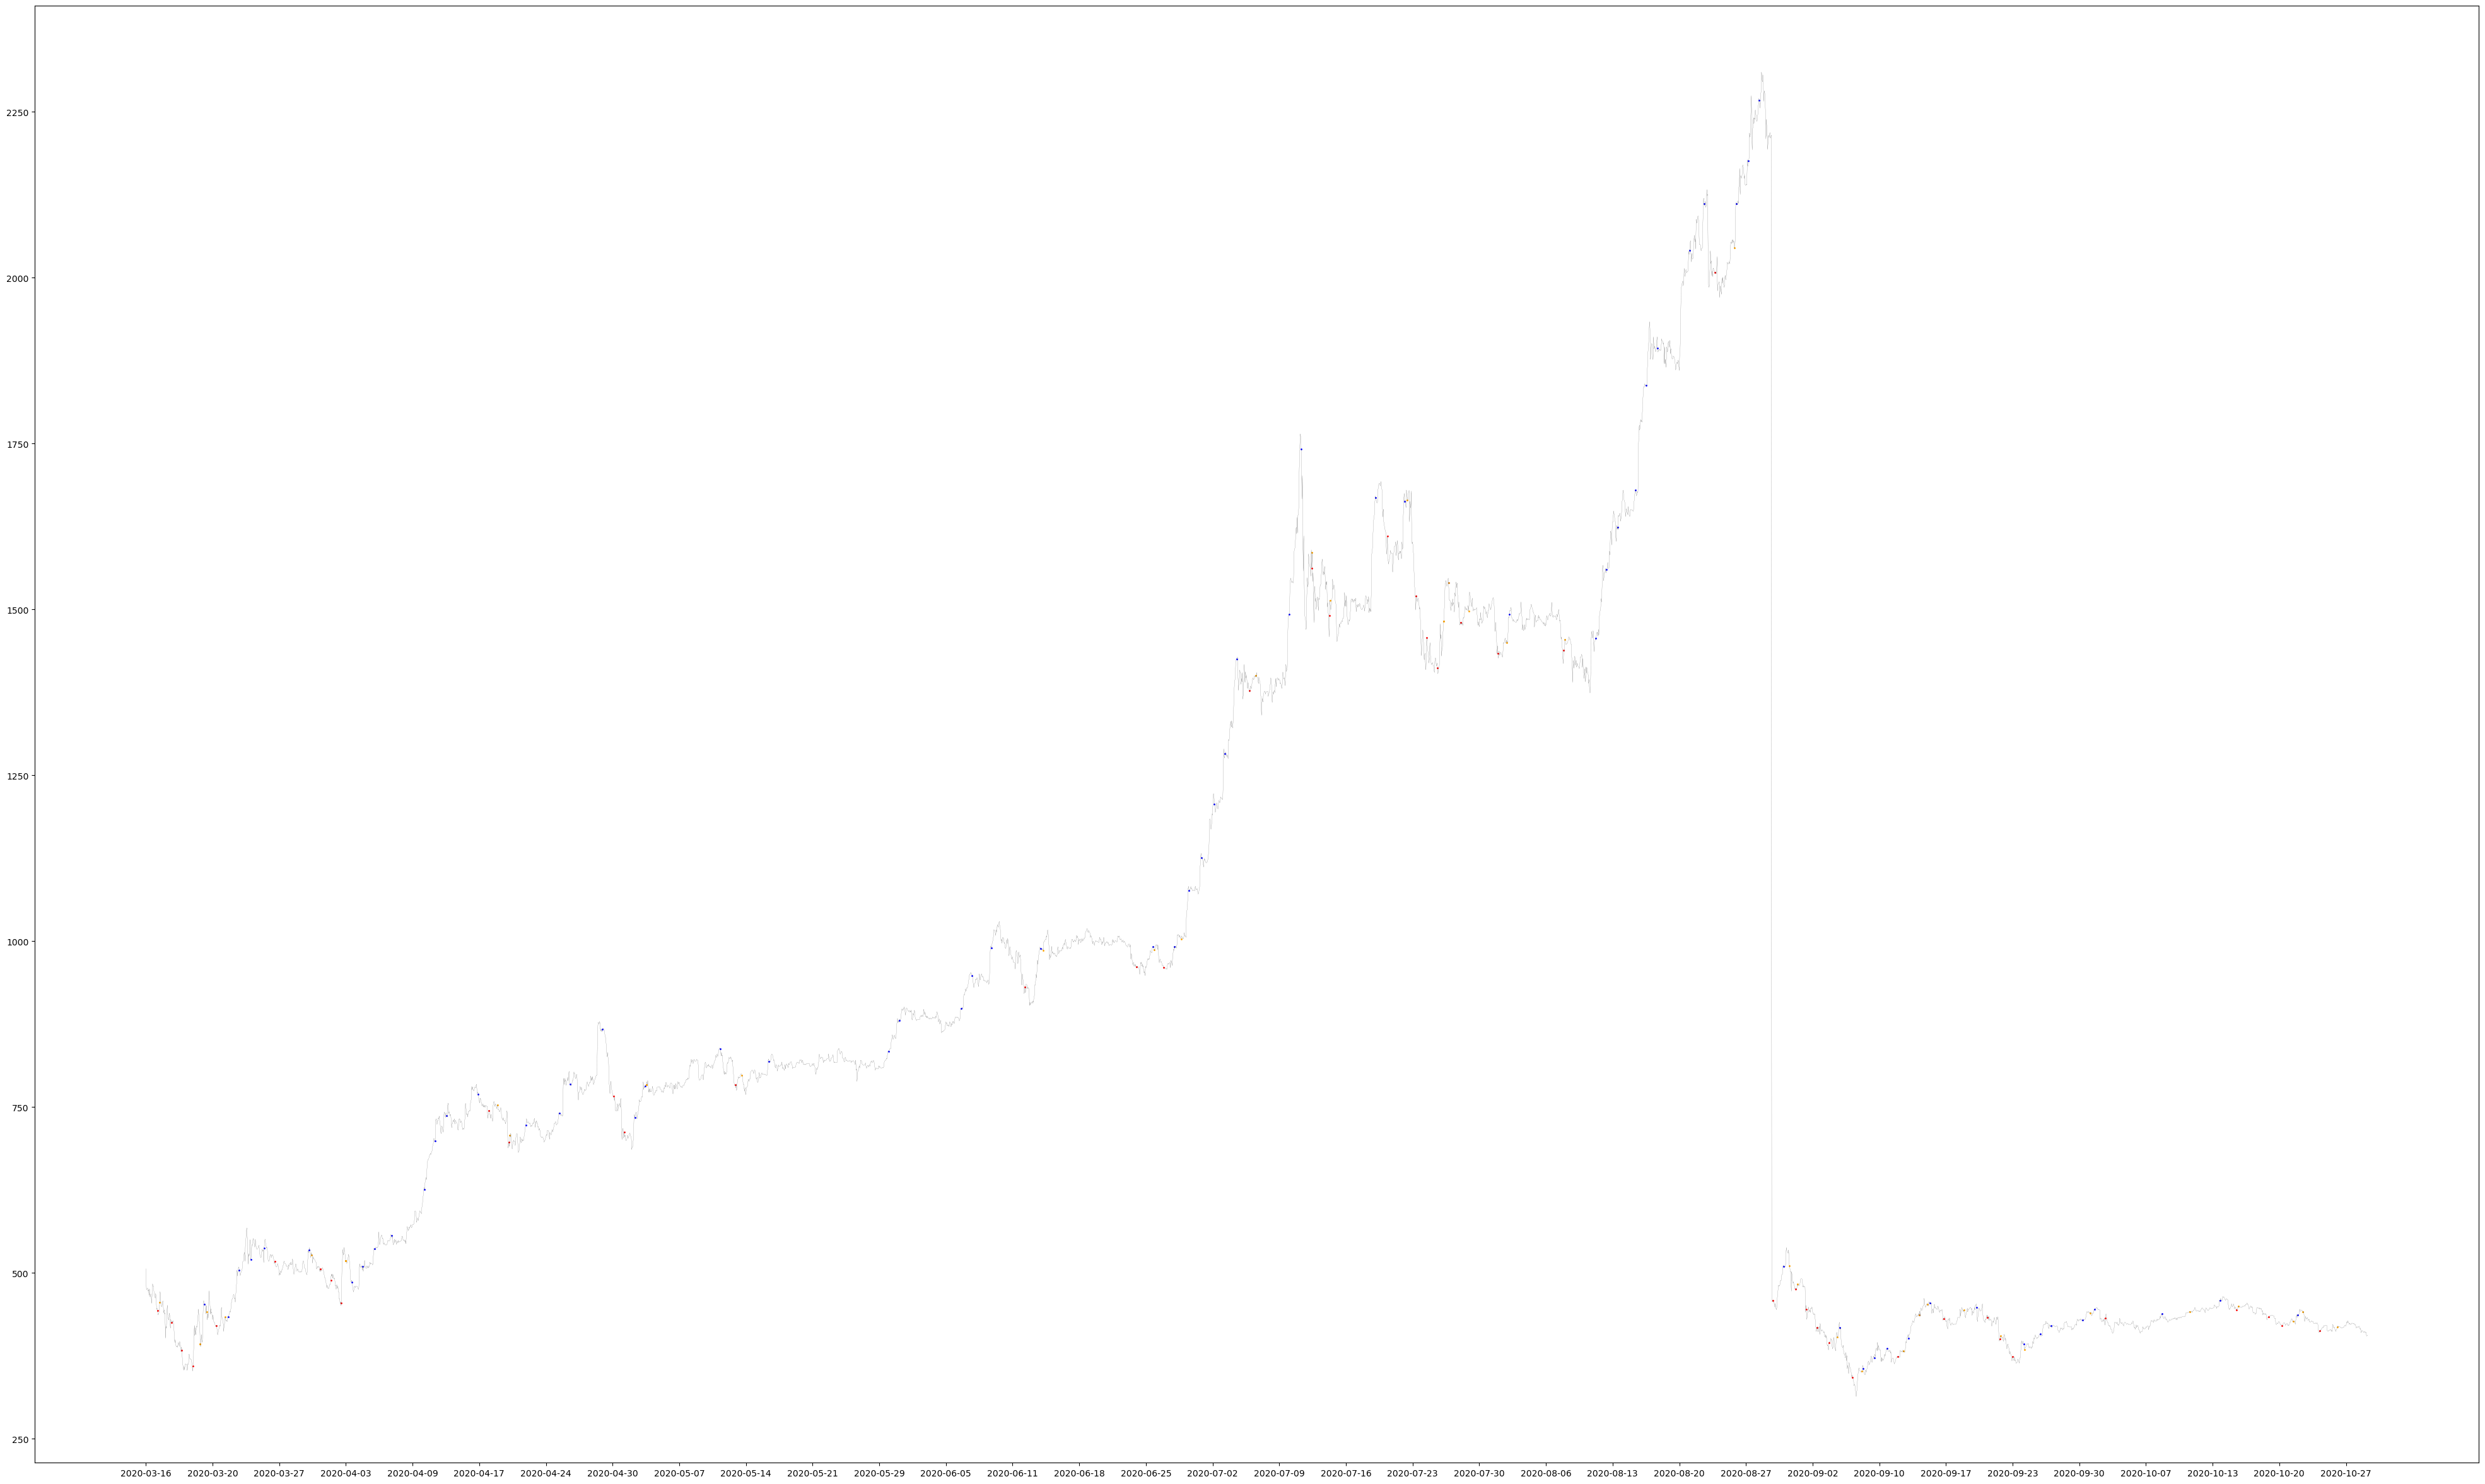

In [103]:
#%matplotlib notebook
%matplotlib inline

from scripts import utils

utils.visualize(ts_time, ts_data, buying_points, selling_points, exit_points)